# Using Dask

## What is Dask ?
Dask is a popular distributed data processing framework for Python. <br />
It provides a simplified mechanisms to parallelize Python code, process out-of-core data and distribute tasks across clusters.<br/>
One of its main advantages is how well integrated it is into the Python ecosystem, facilitating the rewrite of sequential Python code to Dask. 

<div class="alert alert-block alert-info">
    <b> Learning Objectives </b>
    
- Contrast between the different Dask APIs
- Deploy a Dask cluster
- Apply Dask to clean a dataset and train and test a model
</div>

## Introduction to Dask Collection APIs

Dask provides a variety of collections to facilitate distributed processing in Python. <br />
These collections include:

- Dask Bag
- Dask Array
- Dask DataFrames
- Dask Delayed
- Futures

In this section, we will go over the different collections and learn when best to use them.

### Dask Bags

A Dask Bag can be thought of as a parallelized version of a Python iterable (a collection of Python iterables). <br/>
It is mainly used for the parallel processing of unstructured/semi-structured data (e.g. textfiles, json-objects, Python lists).

In [1]:
from dask import bag as db

bag = db.from_sequence(range(1,20))
bag

dask.bag<from_sequence, npartitions=19>

Dask Bags are lazily evaluated, meaning we must compute (via `.compute()`) the data to see the contents of the Dask Bag

In [2]:
bag.compute()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Dask Bags provide implementations to operations such as `map`, `filter`, `groupby` and `fold` to parallel process the data

In [3]:
result = bag.filter(lambda x: x % 2 == 0).map(lambda x: x**2)
result.compute()

[4, 16, 36, 64, 100, 144, 196, 256, 324]

We can also see the resulting graph generated from the computation using `.visualize()`

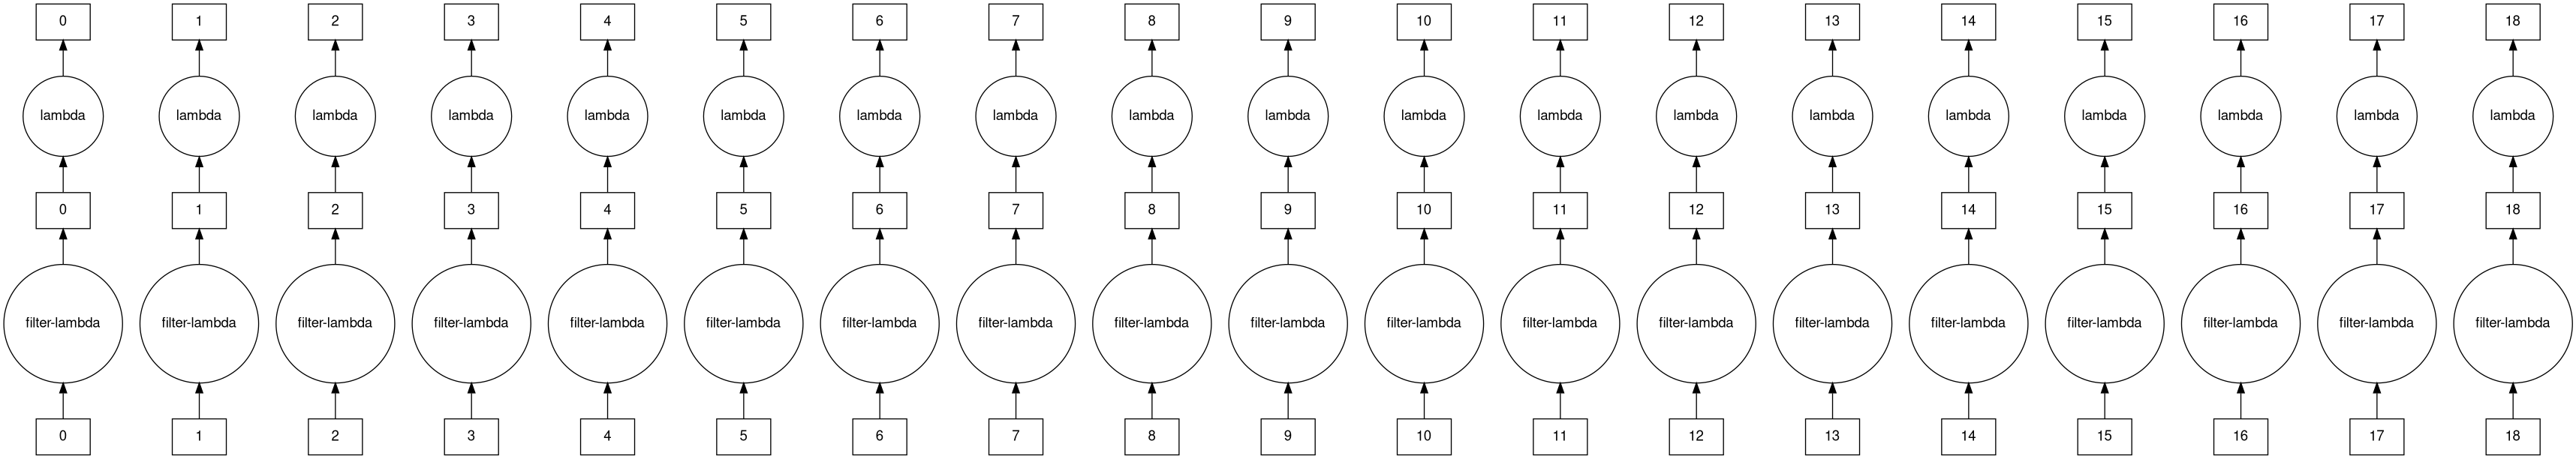

In [4]:
result.visualize(filename="bag.png")

<div class="alert alert-block alert-warning">
<b>Limitations:</b> 
    <ul>
        <li>To bypass the Python's global interpreter lock (GIL), Dask Bags use the multiprocessing scheduler which comes with additional overheads</li>
        <li>They are immutable</li>
        <li>They are slower than their Array and DataFrame counterparts</li>
    </ul>
</div>

### Dask Arrays

Dask Arrays are a collection of NumPy/NumPy-like ("Duck") arrays arranged into a grid.
The API implements a subset of the functionality available in NumPy.<br>
Unlike Dask Bags, Dask Arrays use the multithreaded scheduler by default.

In [5]:
from dask import array as da
from numpy import asarray

# We'll be loading a numpy array into Dask
arr = asarray(range(64)).reshape(4,4,4)
d_arr = da.from_array(arr)

# Like Dask Bags, Dask Arrays are lazily evaluated
# However, we can obtain metadata information by printing the lazy object
d_arr

dask.array<array, shape=(4, 4, 4), dtype=int64, chunksize=(4, 4, 4), chunktype=numpy.ndarray>

Currently the array consists of a single chunk. As we can see, there's only one task and therefore processing in Dask would not improve performance above what is already provided by NumPy. When data becomes larger than memory, Dask will estimate chunk dimensions. Depending on the algorithm, it may be optimal to rechunk to more appropriate dimensions

In [6]:
d_arr = d_arr.rechunk(2,2,2)
d_arr

dask.array<rechunk-merge, shape=(4, 4, 4), dtype=int64, chunksize=(2, 2, 2), chunktype=numpy.ndarray>

Let's perform the same computations that we did for Dask Bags with Dask Arrays using NumPy functionality.

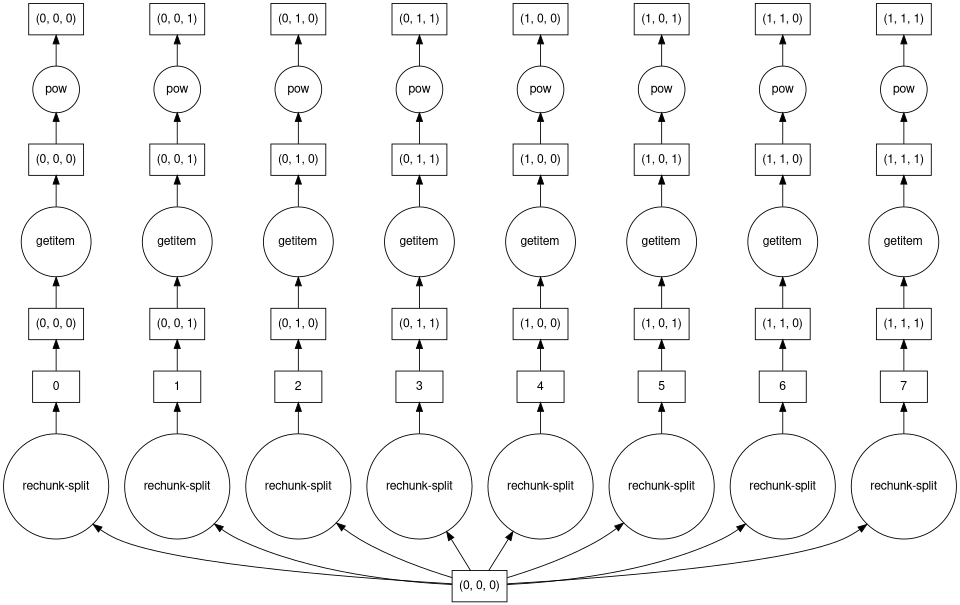

In [7]:
# We know every second element is even. Let's use slicing to filter
d_even = d_arr[:, :, ::2]
d_esqrd = d_even**2
d_esqrd.visualize(filename='array.png', size="10")

In [8]:
d_esqrd.compute()

array([[[   0,    4],
        [  16,   36],
        [  64,  100],
        [ 144,  196]],

       [[ 256,  324],
        [ 400,  484],
        [ 576,  676],
        [ 784,  900]],

       [[1024, 1156],
        [1296, 1444],
        [1600, 1764],
        [1936, 2116]],

       [[2304, 2500],
        [2704, 2916],
        [3136, 3364],
        [3600, 3844]]])

<div class="alert alert-block alert-warning">
<b>Limitation:</b> An important limitation of the Dask Array is that the entire NumPy API is not reimplemented
</div>

### Dask DataFrame

The Dask DataFrame is a collection of Pandas DataFrames or Series aligned along an index. The Dask DataFrame API reimplements part of the Pandas API.<br>
Similar to Dask Arrays, Dask DataFrame used the multithreaded scheduler by default.

In [9]:
from dask import dataframe as dd

# We will be loading the iris dataset
d_df = dd.read_csv('data/iris.csv')
d_df # Dask Dataframes are also lazily evaluated, but we can visualize metadata by printing the object

,sepal_length,sepal_width,petal_length,petal_width,species
npartitions=1,,,,,
,float64,float64,float64,float64,object
,...,...,...,...,...


Let's perform some DataFrame manipulations using pandas API-like functions

In [10]:
# species names are categorical data. Let's use One-hot encoding to view correlations in a heat map
iris_names = d_df["species"].drop_duplicates()

for species in iris_names:
    d_df[species] = 0
    d_df[species] = d_df[species].where(d_df.species != species, 1)
d_df #.visualize('dataframe.png', size="20") 

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
npartitions=1,,,,,,,,
,float64,float64,float64,float64,object,int64,int64,int64
,...,...,...,...,...,...,...,...


In [11]:
# Plot a correlation matrix of the data 
d_df.corr().compute().style.background_gradient(cmap='magma')

,sepal_length,sepal_width,petal_length,petal_width,setosa,versicolor,virginica
sepal_length,1.000000,-0.117570,0.871754,0.817941,-0.717416,0.079396,0.638020
sepal_width,-0.117570,1.000000,-0.428440,-0.366126,0.603348,-0.467703,-0.135645
petal_length,0.871754,-0.428440,1.000000,0.962865,-0.922765,0.201754,0.721011
petal_width,0.817941,-0.366126,0.962865,1.000000,-0.887344,0.117899,0.769445
setosa,-0.717416,0.603348,-0.922765,-0.887344,1.000000,-0.500000,-0.500000
versicolor,0.079396,-0.467703,0.201754,0.117899,-0.500000,1.000000,-0.500000
virginica,0.638020,-0.135645,0.721011,0.769445,-0.500000,-0.500000,1.000000


<div class="alert alert-block alert-warning">
<b>Limitation:</b> An important limitation of the Dask DataFrame is that the entire Pandas API is not reimplemented
</div>

### Dask Delayed

The Dask Delayed API can be used to parallelize processing that cannot be described using the Array/DataFrame APIs.
Tasks which are flagged as delayed are lazily evaluated.

In [12]:
from dask import delayed

# Using the decorator
@delayed
def add(a, b):
    return a+b

def multiply(a, b):
    return a*b

x = []
for i in range(0, 3):
    for j in range(1, 4):
      # multiply didn't have the decorator, but it can be converted to a delayed function by using `delayed()`
      x.append(delayed(multiply)(add(i, j), add(i, j)))

x

[Delayed('multiply-3a618950-b14a-48f3-805c-8f246fb444c9'),
 Delayed('multiply-d28247c3-9d89-4723-b67d-c587e6a30779'),
 Delayed('multiply-40b4ad67-b1b4-4bda-aeeb-f1e093c05eff'),
 Delayed('multiply-ea24ae53-e9f3-4124-8a94-b148d3e3e65a'),
 Delayed('multiply-bad9cb8b-d194-4ae6-b59a-4961da7c62e4'),
 Delayed('multiply-aa5f9728-ea33-4bcb-93bd-ae48048d566b'),
 Delayed('multiply-e472b09f-5e83-4e64-b2a3-9655e7989212'),
 Delayed('multiply-d72b34f6-69ad-40cc-8e43-8001e4b3e3b1'),
 Delayed('multiply-42042186-a58a-429b-bb10-dd50244c4b49')]

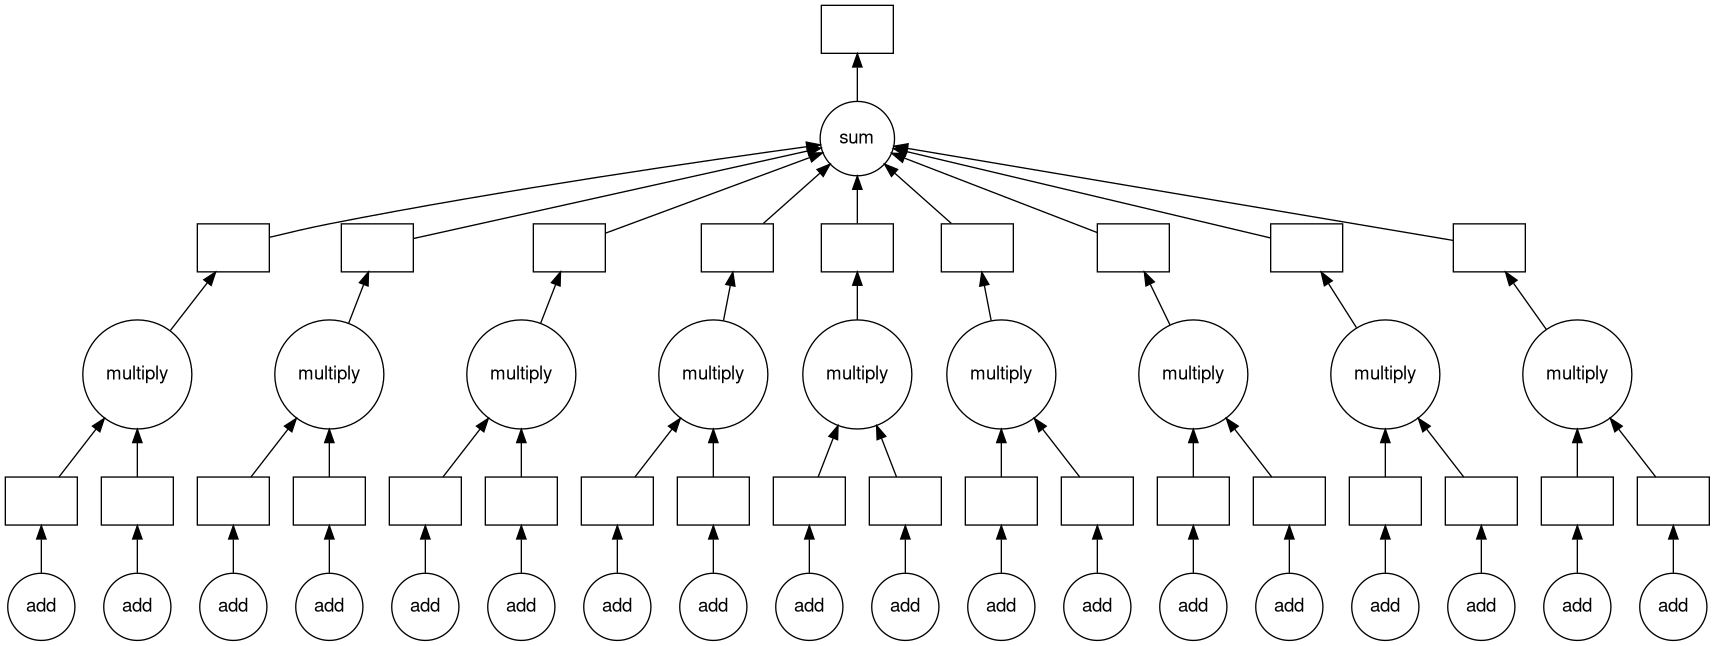

In [13]:
# Let's add an aggregation and visualize the task graph
delayed(sum)(x).visualize(filename='delayed.png')

### Futures

Unlike other Dask collections, Dask futures run in realtime (i.e. no lazy evaluation). They are the distributed extension to Python's
`concurrent.futures`<br>
Like Dask Delayed, it is task-based. <br><br>
Since Dask Futures execute in realtime, tasks must be submitted to a running cluster

In [14]:
from dask.distributed import Client

client = Client(processes=False, n_workers=1, threads_per_worker=1, memory_limit="500MB")  # local workers are threads, not processes

In [15]:
from time import sleep
def sleep_and_inc(elements):
    sleep(1)
    return [e+1 for e in elements]

a = client.submit(sleep_and_inc, range(10))
a

<Future: pending, key: sleep_and_inc-f6d91e96106b35b0d8bb612848c40ac6>

In [16]:
a.result()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Futures can also be passed to other functions even if results are still pending. The tasks will wait until the inputs are obtained before proceeding.

In [17]:
b = client.submit(sum, a)
b

<Future: pending, key: sum-3a819afd27b56052b4a81eee322ee8e6>

In [18]:
b.result()

55

In [19]:
# terminate client
client.close()

## Deploying a Dask Cluster

Dask provides two different types of schedulers:
1. Single-machine scheduler
2. Distributed scheduler

### Single-machine scheduler
This scheduler is the default scheduler of Dask clusters. It is easy to use and can be configured to use local process or thread pools.
However, it is limited to single-machines and does not scale

To use the single-machine scheduler, computing using the Dask collection of choice is sufficient.

In [20]:
from dask import bag as db

db.from_sequence(range(10)).map(lambda x: x+1).compute() # is using the single-machine scheduler with multiprocessing

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Distributed scheduler

The Dask distrbuted scheduler is Dask's scalable scheduler. It can run on both single-machine and distributed clusters and is often the preferred
scheduler, even for single-machines, due to its advanced features.

To use the Dask distributed scheduler, we must first create a client

In [21]:
from dask.distributed import Client

client = Client(n_workers=1, threads_per_worker=1, memory_limit="500MB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 476.84 MiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34395,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 476.84 MiB
Comm: tcp://127.0.0.1:33101,Total threads: 1
Dashboard: http://127.0.0.1:36081/status,Memory: 476.84 MiB
Nanny: tcp://127.0.0.1:32789,


In [22]:
db.from_sequence(range(10)).map(lambda x: x+1).compute() # is using the Dask distributed multiprocessing scheduler

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

When done, we can terminate the cluster using `close()`

In [23]:
client.close()

## Machine Learning with Dask-ML

The Dask-ML uses popular Python machine learning libraries such as scikit-learn and XGBoost to provide scalable machine learning in Dask.

### Data preparation with Dask

When dealing with out-of-core datasets, Dask can both speed-up and simplify the data cleaning process.

For this section, we will use the palmerpenguins dataset to determine species type based on location, and penguin characteristics.

In [24]:
from dask import dataframe as dd
import numpy as np

# We will be loading the palmer penguins dataset
d_df = dd.read_csv('data/penguins.csv')
d_df = d_df.replace("?", np.nan).dropna().astype(dtype={"species": str,
                                                        "island": str,
                                                        "culmen_length_mm": float , 
                                                        "culmen_depth_mm": float, 
                                                        "flipper_length_mm": float,
                                                        "body_mass_g": float,
                                                        "sex": str})
d_df.compute()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [25]:
d_df.describe().compute()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,334.000000,334.000000,334.000000,334.000000
mean,43.994311,17.160479,201.014970,4209.056886
std,5.460521,1.967909,14.022175,804.836129
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.575000,18.700000,213.000000,4793.750000
max,59.600000,21.500000,231.000000,6300.000000


Let's check the distribution of the penguins across islands

In [26]:
d_df[["species", "island"]].groupby(["species", "island"]).count().compute()

Empty DataFrame
Columns: []
Index: [(Adelie, Biscoe), (Adelie, Dream), (Adelie, Torgersen), (Chinstrap, Dream), (Gentoo, Biscoe)]

We'll drop the Island column as it gives significant information on species type

In [27]:
d_df = d_df.drop("island", axis=1)

We can also check species distribution across the dataset

/home/valeriehayot/ericsson/dask/.venv/lib64/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <BarContainer object of 3 artists> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


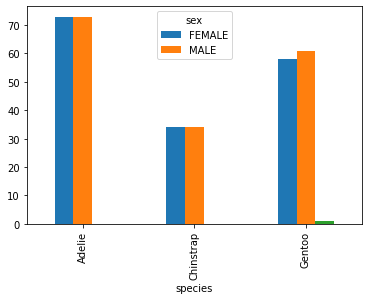

In [28]:
_ = d_df[["species", "sex"]].groupby(["species", "sex"]).size().reset_index() \
                            .rename(columns={0: "count"}).compute().pivot(index="species", columns="sex", values="count").plot.bar()

While there is an equal number of male and female penguins, the dataset is somewhat unbalanced.
We won't address the imbalance, but we will remove the one row where the sex is unknown.

In [29]:
d_df = d_df[d_df["sex"] != "_"]

Here we have quite a bit of nominal data that needs to be encoded before passing it to a classifier. As none of the nominal data has an order to it, we will one-hot encode it. As we only want to one-hot encode the features and not the label, we will first separate labels and features.

In [30]:
X = d_df.iloc[:, 1:7] # features
y = d_df["species"].to_frame() # labels

Before being able to one-hot encode in Dask, we must first use the `Categorizer` to label non-numeric columns as Pandas categories

In [31]:
from dask_ml.preprocessing import Categorizer

ce = Categorizer()
X = ce.fit_transform(X)
y = ce.fit_transform(y)
X

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
npartitions=1,,,,,
,float64,float64,float64,float64,category[known]
,...,...,...,...,...


We can now one-hot encode the data using the `DummyEncoder()`

In [32]:
from dask_ml.preprocessing import DummyEncoder

de = DummyEncoder()
X = de.fit_transform(X)
X.compute()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,sex_FEMALE
0,39.1,18.7,181.0,3750.0,1,0
1,39.5,17.4,186.0,3800.0,0,1
2,40.3,18.0,195.0,3250.0,0,1
4,36.7,19.3,193.0,3450.0,0,1
5,39.3,20.6,190.0,3650.0,1,0
...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,0,1
340,46.8,14.3,215.0,4850.0,0,1
341,50.4,15.7,222.0,5750.0,1,0
342,45.2,14.8,212.0,5200.0,0,1


The labels also need to be in numeric format for Dask, but in this case we can use the `LabelEncoder` to map the IDs to numeric values. 

In [33]:
from dask_ml.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
y = dd.from_array(y).to_frame().rename(columns={0:"species_id"}).reset_index().drop("index", axis=1)["species_id"]
y.compute()

/home/valeriehayot/ericsson/dask/.venv/lib64/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0      0
1      0
2      0
3      0
4      0
      ..
328    2
329    2
330    2
331    2
332    2
Name: species_id, Length: 333, dtype: int64

To split data into training and test sets, we can use Dask-ML's `train_test_split()` function

In [34]:
from dask_ml.model_selection import train_test_split

# X denotes the features, y denote the labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
X_test.compute()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,sex_FEMALE
133,37.5,18.5,199.0,4475.0,1,0
93,39.6,18.1,186.0,4450.0,1,0
67,41.1,19.1,188.0,4100.0,1,0
110,38.1,16.5,198.0,3825.0,0,1
119,41.1,18.6,189.0,3325.0,1,0
...,...,...,...,...,...,...
92,34.0,17.1,185.0,3400.0,0,1
165,52.0,18.1,201.0,4050.0,1,0
292,48.2,15.6,221.0,5100.0,1,0
116,38.6,17.0,188.0,2900.0,0,1


### Classification with Dask-ML

Now that we've split our training and test data, we can perform classification to train a model to predict species type.<br><br>
Dask-ML currently offers a few classifiers/regressors that parallelize scikit-learn models. Here we use the BlockwiseVotingClassifier
that will perform scikit-learn's RidgeClassifier on each partition of the Dask Dataframe and then aggregate the results via a voting mechanism.

In [35]:
from dask_ml.ensemble import BlockwiseVotingClassifier
import sklearn.linear_model

In [36]:
subestimator = sklearn.linear_model.RidgeClassifier(random_state=0)
bvx = BlockwiseVotingClassifier(subestimator, classes=y.drop_duplicates().compute())
bvx.fit(X_train, y_train)
print("Prediction accuracy:", bvx.score(X_test, y_test))

Prediction accuracy: 0.9859154929577465
